# Sourmash Analysis

## Comparison of 42 _Shewanella algae_ genomes

### Author: Shawn M Higdon

### Date: December 10, 2021

> Use sourmash to generate WGS sketches for the 42 _S. algae_ genomes and compare them to each other to assess their phylogenomic relationships to one another.

In [4]:
%%bash

mkdir -p sourmash/assemblies && ls



diGMP_pangenome_analysis.ipynb
kegg_maps
pg_ref_map.csv
pg_rep_emapper_1e-3
pg_rep_emapper_1e-6
pg_representatives.faa
PRJNA526057_AssemblyDetails.txt
roary_KIonly_id90
r_plots
sourmash
Sourmash_analysis.ipynb
strain_metadata.csv


### Parse NCBI Bioproject Genome Assembly Accession List from Project Summary file

In [92]:
%%bash

# create genome assembly accession to strain map file
cat PRJNA526057_AssemblyDetails.txt | sed -e 's/# //g' | tail -n +2 | awk '{FS="\t";OFS="\t"}{print $1, $6}' | sed -e 's/CCUG-//g' > assembly_strain_map.tsv

# preview map file
head assembly_strain_map.tsv

# create list of accessions to download from NCBI
cat assembly_strain_map.tsv | tail -n +2 | awk '{print $1}' > salgae_asm_acc_list.txt
echo -e "\nThis is a preview of the list of accessions for download...\n"
head salgae_asm_acc_list.txt

Assembly	Strain
GCA_017570325.1	150735
GCA_017570225.1	G1
GCA_017570125.1	A59
GCA_017570045.1	A291
GCA_009183365.2	CECT-5071
GCA_017580715.1	404
GCA_017580705.1	789
GCA_017580505.1	48086
GCA_017580485.1	38646

This is a preview of the list of accessions for download...

GCA_017570325.1
GCA_017570225.1
GCA_017570125.1
GCA_017570045.1
GCA_009183365.2
GCA_017580715.1
GCA_017580705.1
GCA_017580505.1
GCA_017580485.1
GCA_017580455.1


### Download genome assemblies and rename files

In [94]:
%%bash

# purge assembly folder
rm -rf sourmash/assemblies/*

# download the genome assemblies
ncbi-genome-download \
    -s genbank \
    -F fasta \
    -A salgae_asm_acc_list.txt \
    -o sourmash/assemblies \
    --flat-output \
    -p 4 \
    -v \
    bacteria

# count number of assemblies
ls sourmash/assemblies/ | wc -l && echo -e "\n"

# rename all the downloaded assemblies with the map file
for i in sourmash/assemblies/*.gz
do
    root=`basename $i`
    root=`echo $root | cut -d_ -f2`
    name=GCA_${root}
    #echo $name
    map="$(grep "$name" assembly_strain_map.tsv | cut -f2)"
    #echo $map
    mv $i sourmash/assemblies/${map}.fna.gz
done

# inspect
ls sourmash/assemblies | head

42


12945.fna.gz
150735.fna.gz
15259.fna.gz
159418.fna.gz
20533.fna.gz
24987.fna.gz
28011.fna.gz
38646.fna.gz
404.fna.gz
48086.fna.gz


INFO: Using cached summary.
INFO: Checking record 'GCA_009183365.2'
INFO: Checking record 'GCA_017570045.1'
INFO: Checking record 'GCA_017570125.1'
INFO: Checking record 'GCA_017570225.1'
INFO: Checking record 'GCA_017570325.1'
INFO: Checking record 'GCA_017579985.1'
INFO: Checking record 'GCA_017580005.1'
INFO: Checking record 'GCA_017580015.1'
INFO: Checking record 'GCA_017580025.1'
INFO: Checking record 'GCA_017580065.1'
INFO: Checking record 'GCA_017580085.1'
INFO: Checking record 'GCA_017580095.1'
INFO: Checking record 'GCA_017580105.1'
INFO: Checking record 'GCA_017580125.1'
INFO: Checking record 'GCA_017580145.1'
INFO: Checking record 'GCA_017580185.1'
INFO: Checking record 'GCA_017580205.1'
INFO: Checking record 'GCA_017580215.1'
INFO: Checking record 'GCA_017580225.1'
INFO: Checking record 'GCA_017580235.1'
INFO: Checking record 'GCA_017580285.1'
INFO: Checking record 'GCA_017580295.1'
INFO: Checking record 'GCA_017580325.1'
INFO: Checking record 'GCA_017580335.1'
INFO: Checki

## MinHash sketch genome assemblies

In [99]:
%%bash

# Create minhash sketch for each assembly
cd sourmash/assemblies/

for i in *.gz
do
    name=`echo $i | cut -d. -f1`
    sourmash sketch dna \
        -p k=31,abund,scaled=1000 \
        -f \
        -o ${name}.sig \
        $i
done


== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: 12945.fna.gz
Computing a total of 1 signature(s).
... reading sequences from 12945.fna.gz
calculated 1 signatures for 40 sequences in 12945.fna.gz
saved signature(s) to 12945.sig. Note: signature license is CC0.

== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: 150735.fna.gz
Computing a total of 1 signature(s).
... reading sequences from 150735.fna.gz
calculated 1 signatures for 1 sequences in 150735.fna.gz
saved signature(s) to 150735.sig. Note: signature license is CC0.

== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: 15259.fna.gz
Computing a total of 1 signature(s).
... reading sequences from 15259.fna.gz
calculated 1 signatures for 50 sequences in 15259.fna.gz
saved sig

### Compare assembly minhash genome sketches

In [107]:
%%bash

mkdir -p sourmash/assemblies/{cmp_sim,cmp_cont}

rm -rf sourmash/assemblies/salgae_42_cmp*

cd sourmash/assemblies/

# similarity
sourmash compare -k 31 -p 4 -o cmp_sim/salgae_42_cmp_sim --csv cmp_sim/salgae_42_cmp_sim.csv *.sig

# containment
sourmash compare -k 31 -p 4 --containment -o cmp_cont/salgae_42_cmp_cont --csv cmp_cont/salgae_42_cmp_cont.csv *.sig

ls cmp_sim/salgae_42*
head cmp_sim/salgae_42_cmp_sim.labels.txt

ls cmp_cont/salgae_42*
head cmp_cont/salgae_42_cmp_cont.labels.txt

min similarity in matrix: 0.340
min similarity in matrix: 0.522
cmp_sim/salgae_42_cmp_sim
cmp_sim/salgae_42_cmp_sim.csv
cmp_sim/salgae_42_cmp_sim.labels.txt
12945.fna.gz
150735.fna.gz
15259.fna.gz
159418.fna.gz
20533.fna.gz
24987.fna.gz
28011.fna.gz
38646.fna.gz
404.fna.gz
48086.fna.gz
cmp_cont/salgae_42_cmp_cont
cmp_cont/salgae_42_cmp_cont.csv
cmp_cont/salgae_42_cmp_cont.labels.txt
12945.fna.gz
150735.fna.gz
15259.fna.gz
159418.fna.gz
20533.fna.gz
24987.fna.gz
28011.fna.gz
38646.fna.gz
404.fna.gz
48086.fna.gz



== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 42 signatures total.                                                    

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 41 done in 0.00000 seconds
Time taken to compare all pairs parallely is 0.56786 seconds 
saving labels to: cmp_sim/salgae_42_cmp_sim.labels.txt
saving comparison matrix to: cmp_sim/salgae_42_cmp_sim

== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 42 signatures total.                                                    
NOTE: --containment and --max-containment ignore signature abundances.

saving labels to: cmp_cont/salgae_42_cmp_cont.labels.txt
saving comparison matrix to: cmp_cont/salgae_42_cmp_cont


### Sourmash GTDB r202 search

> Query each genome sketch against the GTDB r202 database

In [110]:
%%bash

cd sourmash/assemblies/

for i in *.sig
do
    bname=`basename $i`
    bname=`echo $bname | cut -d. -f1`
    #echo $bname
    sourmash search \
        --best-only \
        -k 31 \
        --ignore-abundance \
        -o ${bname}_best_match.csv \
        $i \
        /ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip
done


10 matches; showing first 1:
similarity   match
----------   -----
 51.2%       GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM3721...

9 matches; showing first 1:
similarity   match
----------   -----
 46.4%       GCF_009183365.1 Shewanella algae strain=CECT 5071, ASM918...

6 matches; showing first 1:
similarity   match
----------   -----
 48.9%       GCF_007636495.1 Shewanella algae strain=TYL, ASM763649v1

6 matches; showing first 1:
similarity   match
----------   -----
 60.5%       GCF_008119825.1 Shewanella algae strain=SYC, ASM811982v1

11 matches; showing first 1:
similarity   match
----------   -----
 47.7%       GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM3721...

6 matches; showing first 1:
similarity   match
----------   -----
 40.4%       GCF_002237105.1 Shewanella algae strain=MN-01, ASM223710v1

8 matches; showing first 1:
similarity   match
----------   -----
 48.8%       GCF_007636355.1 Shewanella algae strain=JFC3, ASM763635v1

7 matches; showing firs


== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting specified query k=31
loaded query: 12945.fna.gz... (k=31, DNA)
loaded 1 databases.                                                            
** reporting only one match because --best-only was set
cat: .tsv: No such file or directory

== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting specified query k=31
loaded query: 150735.fna.gz... (k=31, DNA)
loaded 1 databases.                                                            
** reporting only one match because --best-only was set
cat: .tsv: No such file or directory

== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting specified query k=31
loaded query: 15259.fna.gz... (k=31, DNA)
loaded 1 databases.                                                            
** reporting only one match becau

CalledProcessError: Command 'b'\ncd sourmash/assemblies/\n\nfor i in *.sig\ndo\n    bname=`basename $i`\n    bname=`echo $bname | cut -d. -f1`\n    #echo $bname\n    sourmash search \\\n        --best-only \\\n        -k 31 \\\n        --ignore-abundance \\\n        -o ${bname}_best_match.tsv \\\n        $i \\\n        /ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip\n    cat $bname_best_match.tsv\ndone\n'' returned non-zero exit status 1.

In [108]:
%%bash

sourmash search --help

usage:  search [-h] [-q] [--threshold T] [--save-matches FILE] [--best-only]
               [-n N] [--containment] [--max-containment] [--ignore-abundance]
               [-o FILE] [--md5 MD5] [-k K] [--protein] [--no-protein]
               [--dayhoff] [--no-dayhoff] [--hp] [--no-hp] [--dna] [--no-dna]
               [--picklist PICKLIST] [--picklist-require-all] [--scaled FLOAT]
               query databases [databases ...]

positional arguments:
  query                 query signature
  databases             signatures/SBTs to search

optional arguments:
  -h, --help            show this help message and exit
  -q, --quiet           suppress non-error output
  --threshold T         minimum threshold for reporting matches; default=0.08
  --save-matches FILE   output matching signatures to the specified file
  --best-only           report only the best match (with greater speed)
  -n N, --num-results N
                        number of results to report
  --containment         score 


== This is sourmash version 4.2.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==



### Create GTDB best hit map file

In [119]:
%%bash

cd sourmash/assemblies/

rm salgae_gtdb_sim_map.csv

head -n +1 12945_best_match.csv > salgae_gtdb_sim_map.csv

for i in *_best_match.csv
do
    head -n +2 $i | tail -n+2 >> salgae_gtdb_sim_map.csv
done

head salgae_gtdb_sim_map.csv

similarity,name,filename,md5,query_filename,query_name,query_md5
0.5123766135155656,"GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM372145v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,30b149c9a32b67cdff91ce5465858b8e,12945.fna.gz,,361fbc7c
0.4643178410794603,"GCF_009183365.1 Shewanella algae strain=CECT 5071, ASM918336v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,44c38b763e823efa72b080c998e62eeb,150735.fna.gz,,fe52a49b
0.4888923171860537,"GCF_007636495.1 Shewanella algae strain=TYL, ASM763649v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,774a8f9cdb1f7a05dce3cb6086c5717d,15259.fna.gz,,80ea6e28
0.6053031582502956,"GCF_008119825.1 Shewanella algae strain=SYC, ASM811982v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,d3811c9aaad9985648244c068b740259,159418.fna.gz,,7bd687b5
0.4774721189591078,"GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM372145v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,30b149c9a32b67cdff91ce5465858b8e,20533.fna.gz,,9c3681d3
0.

### Tidy up the GTDB best match map file

In [1]:
%%bash

head sourmash/assemblies/salgae_gtdb_sim_map.csv

cd sourmash/assemblies/

# select and parse relevant fields
awk -F ',' -v OFS="," '{ sub("similarity", "gtdb_similarity", $1); \
                         sub(".*=", "", $2); \
                         sub(" ", "-", $2); \
                         sub(".fna.gz", "", $6); \
                         sub("name","gtdb_ref_strain", $2); \
                         print $1,$2,$6 }' salgae_gtdb_sim_map.csv > salgae_gtdb_sim_map.ps.csv

head salgae_gtdb_sim_map.ps.csv

similarity,name,filename,md5,query_filename,query_name,query_md5
0.5123766135155656,"GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM372145v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,30b149c9a32b67cdff91ce5465858b8e,12945.fna.gz,,361fbc7c
0.4643178410794603,"GCF_009183365.1 Shewanella algae strain=CECT 5071, ASM918336v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,44c38b763e823efa72b080c998e62eeb,150735.fna.gz,,fe52a49b
0.4888923171860537,"GCF_007636495.1 Shewanella algae strain=TYL, ASM763649v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,774a8f9cdb1f7a05dce3cb6086c5717d,15259.fna.gz,,80ea6e28
0.6053031582502956,"GCF_008119825.1 Shewanella algae strain=SYC, ASM811982v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,d3811c9aaad9985648244c068b740259,159418.fna.gz,,7bd687b5
0.4774721189591078,"GCF_003721455.1 Shewanella algae strain=KC-Na-R1, ASM372145v1",/ceph/db/sourmash/gtdb-rs202.genomic.k31.sbt.zip,30b149c9a32b67cdff91ce5465858b8e,20533.fna.gz,,9c3681d3
0.

### Make plot in R

> switch to IR kernel
>
> The distance matrix generated by `sourmash compare` was visualized using the R package `ComplexHeatmap 2.8.0`.

1. Read in comparative matrix
2. Add isolate metadata for each isolate
3. Plot heatmap


In [79]:
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(viridisLite))
suppressPackageStartupMessages(library(RColorBrewer))

In [80]:
# Create Data Frame with Shewanella Isolate Metadata

# read in map file of isolate to patient id source. 
iso_meta <- read_csv("strain_metadata_smash.csv", col_names = TRUE, col_types = c("cddc"))
head(iso_meta)

# read in salgae gtdb strain similarity results map file
iso_gtdb <- read_csv("sourmash/assemblies/salgae_gtdb_sim_map.ps.csv", col_names = TRUE, col_types = c("dcc"))
head(iso_gtdb)

# merge into one isolation source metadata table
iso_md <- full_join(iso_meta, iso_gtdb, by = c("org" = "query_name"))
nrow(iso_md)
# Print Overview
iso_md

# range metadata
range(iso_md$gen_size_Mb)
range(iso_md$p_GC)
range(iso_md$gtdb_similarity)

# summarize by GTDB ref

iso_md %>%
    group_by(gtdb_ref_strain) %>%
    count()

org,gen_size_Mb,p_GC,source
<chr>,<dbl>,<dbl>,<chr>
CECT-5071,4.92,53.1,Alga
G1,4.89,53.0,Human
A291,4.97,53.0,Fish
A59,4.82,53.1,Bird
150735,5.07,52.8,Human
SF7,4.84,53.0,Human


gtdb_similarity,gtdb_ref_strain,query_name
<dbl>,<chr>,<chr>
0.5123766,KC-Na-R1,12945
0.4643178,CECT-5071,150735
0.4888923,TYL,15259
0.6053032,SYC,159418
0.4774721,KC-Na-R1,20533
0.4038121,MN-01,24987


[1] 42

org,gen_size_Mb,p_GC,source,gtdb_similarity,gtdb_ref_strain
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
CECT-5071,4.92,53.1,Alga,0.9995819,CECT-5071
G1,4.89,53.0,Human,0.5343375,CSB04KR
A291,4.97,53.0,Fish,0.4865522,JFC2
A59,4.82,53.1,Bird,0.5014897,TYL
150735,5.07,52.8,Human,0.4643178,CECT-5071
SF7,4.84,53.0,Human,0.4841713,CECT-5071
HUD-I2,4.93,52.9,Human,0.4839544,YHL
HUD-H4,4.93,52.9,Human,0.4839544,YHL
HUD-G3,4.98,52.8,Human,0.4703817,KC-Na-R1


[1] 4.66 5.07

[1] 52.8 53.2

[1] 0.4038121 0.9995819

gtdb_ref_strain,n
<chr>,<int>
18064-CSB-B-B,1
20-23R,1
CECT-5071,10
CHL,1
CSB04KR,2
JFC2,3
JFC3,6
KC-Na-R1,3
MN-01,1


### Create Data Frame for plot

org,gen_size_Mb,p_GC,source,gtdb_similarity,gtdb_ref_strain,gtdb_color
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
CECT-5071,4.92,53.1,Alga,0.9995819,CECT-5071,#DECBE4
G1,4.89,53.0,Human,0.5343375,CSB04KR,#FB8072
A291,4.97,53.0,Fish,0.4865522,JFC2,#FFFF33
A59,4.82,53.1,Bird,0.5014897,TYL,#B3E2CD
150735,5.07,52.8,Human,0.4643178,CECT-5071,#DECBE4
SF7,4.84,53.0,Human,0.4841713,CECT-5071,#DECBE4


[1] 0.5328999

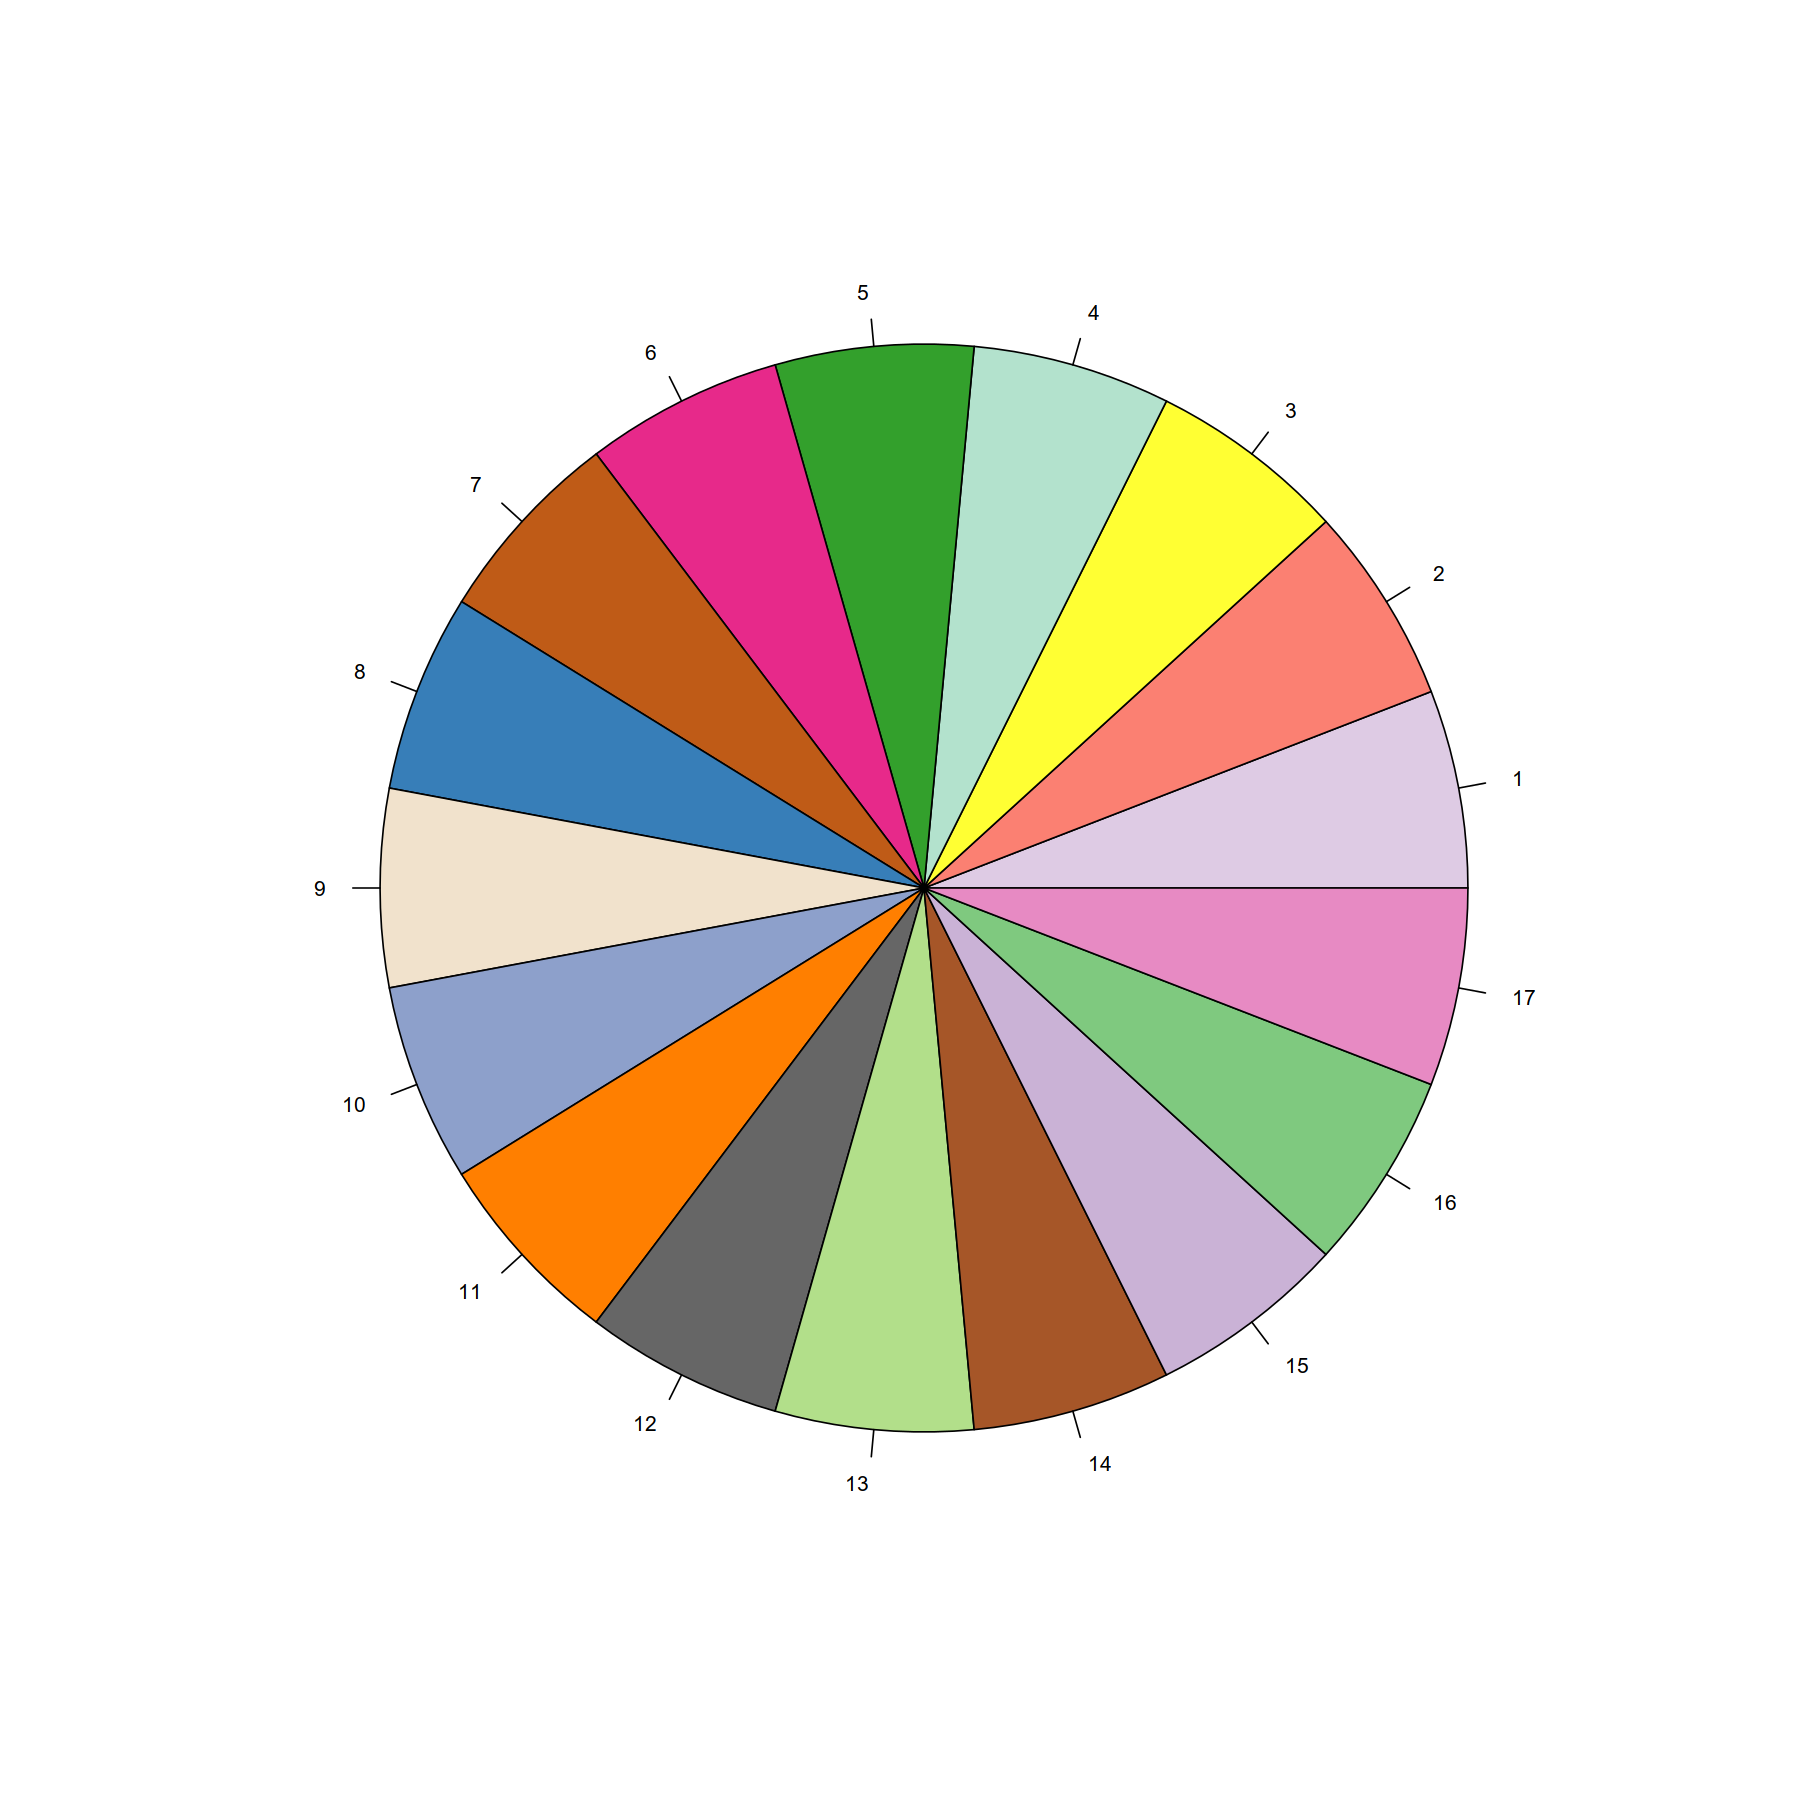

In [122]:
# create unique color for each GTDB reference strain
n_colors <- length(unique(iso_md$gtdb_ref_strain))

palette_info <- brewer.pal.info[brewer.pal.info$category == "qual", ]  # Extract color info
palette_all <- unlist(mapply(brewer.pal,                     # Create vector with all colors
                              palette_info$maxcolors,
                              rownames(palette_info)))

set.seed(1988)                                             # Set random seed
src_colors <- sample(palette_all, n_colors)                    # Sample colors

pie(rep(1, n_colors),                                         # Draw colors in pie chart
    col = src_colors)

gtdb_color_df <- data.frame(gtdb_ref_strain=unique(iso_md$gtdb_ref_strain),
                           gtdb_color= src_colors)



# add to iso_md
iso_md$gtdb_color <- gtdb_color_df$gtdb_color[match(iso_md$gtdb_ref_strain, gtdb_color_df$gtdb_ref_strain)]

head(iso_md)

mean(iso_md$gtdb_similarity)

In [82]:
# read in sourmash comparison matrix
smash.cmp.salgae <- read.csv("sourmash/assemblies/cmp_sim/salgae_42_cmp_sim.csv", header = TRUE, check.names = FALSE)

range(smash.cmp.salgae)


# tidy column names
colnames(smash.cmp.salgae) <- sub(".fna.gz", "", colnames(smash.cmp.salgae))

# set rownames == colnames
rownames(smash.cmp.salgae) <- colnames(smash.cmp.salgae)

# add metadata to smash cmp dataframe
smash.cmp.salgae$gen_size_Mb <- iso_md$gen_size_Mb[match(rownames(smash.cmp.salgae), iso_md$org)]
smash.cmp.salgae$p_GC <- iso_md$p_GC[match(rownames(smash.cmp.salgae), iso_md$org)]
smash.cmp.salgae$source <- iso_md$source[match(rownames(smash.cmp.salgae), iso_md$org)]
smash.cmp.salgae$gtdb_similarity <- iso_md$gtdb_similarity[match(rownames(smash.cmp.salgae), iso_md$org)]
smash.cmp.salgae$gtdb_ref_strain <- iso_md$gtdb_ref_strain[match(rownames(smash.cmp.salgae), iso_md$org)]
smash.cmp.salgae$gtdb_color <- iso_md$gtdb_color[match(rownames(smash.cmp.salgae), iso_md$org)]


#inspect merge
head(as.data.frame(smash.cmp.salgae[,43:48]))

[1] 0.3398209 1.0000000

,gen_size_Mb,p_GC,source,gtdb_similarity,gtdb_ref_strain,gtdb_color
,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
12945,4.88,53.0,Human,0.5123766,KC-Na-R1,#E7298A
150735,5.07,52.8,Human,0.4643178,CECT-5071,#DECBE4
15259,4.89,53.0,Human,0.4888923,TYL,#B3E2CD
159418,4.77,53.0,Human,0.6053032,SYC,#666666
20533,4.84,53.0,Human,0.4774721,KC-Na-R1,#E7298A
24987,4.81,53.0,Human,0.4038121,MN-01,#E78AC3


In [83]:
# create named list for mapping gtdb ref strain to respective color
gtdb_colors <- setNames(as.character(smash.cmp.salgae$gtdb_color), as.character(smash.cmp.salgae$gtdb_ref_strain))
gtdb_colors

KC-Na-R1     CECT-5071           TYL           SYC      KC-Na-R1 
    "#E7298A"     "#DECBE4"     "#B3E2CD"     "#666666"     "#E7298A" 
        MN-01          JFC3     CECT-5071       CSB04KR     CECT-5071 
    "#E78AC3"     "#377EB8"     "#DECBE4"     "#FB8072"     "#DECBE4" 
    CECT-5071          SYT2          JFC3           TYL        20-23R 
    "#DECBE4"     "#7FC97F"     "#377EB8"     "#B3E2CD"     "#CAB2D6" 
         JFC3           YHL     CECT-5071          JFC2           YTH 
    "#377EB8"     "#33A02C"     "#DECBE4"     "#FFFF33"     "#A65628" 
         JFC3           YHL         Sh392          JFC2          SYT1 
    "#377EB8"     "#33A02C"     "#B2DF8A"     "#FFFF33"     "#BF5B17" 
    NCTC10738           CHL 18064-CSB-B-B     CECT-5071           TYL 
    "#FF7F00"     "#8DA0CB"     "#F1E2CC"     "#DECBE4"     "#B3E2CD" 
         JFC3          JFC3          JFC2          SYT1     CECT-5071 
    "#377EB8"     "#377EB8"     "#FFFF33"     "#BF5B17"     "#DECBE4" 
    CECT-5071       CSB04KR     CECT-5071      KC-Na-R1           YHL 
    "#DECBE4"     "#FB8072"     "#DECBE4"     "#E7298A"     "#33A02C" 
          YHL     CECT-5071 
    "#33A02C"     "#DECBE4"

### Plot Heatmap

png 
  2

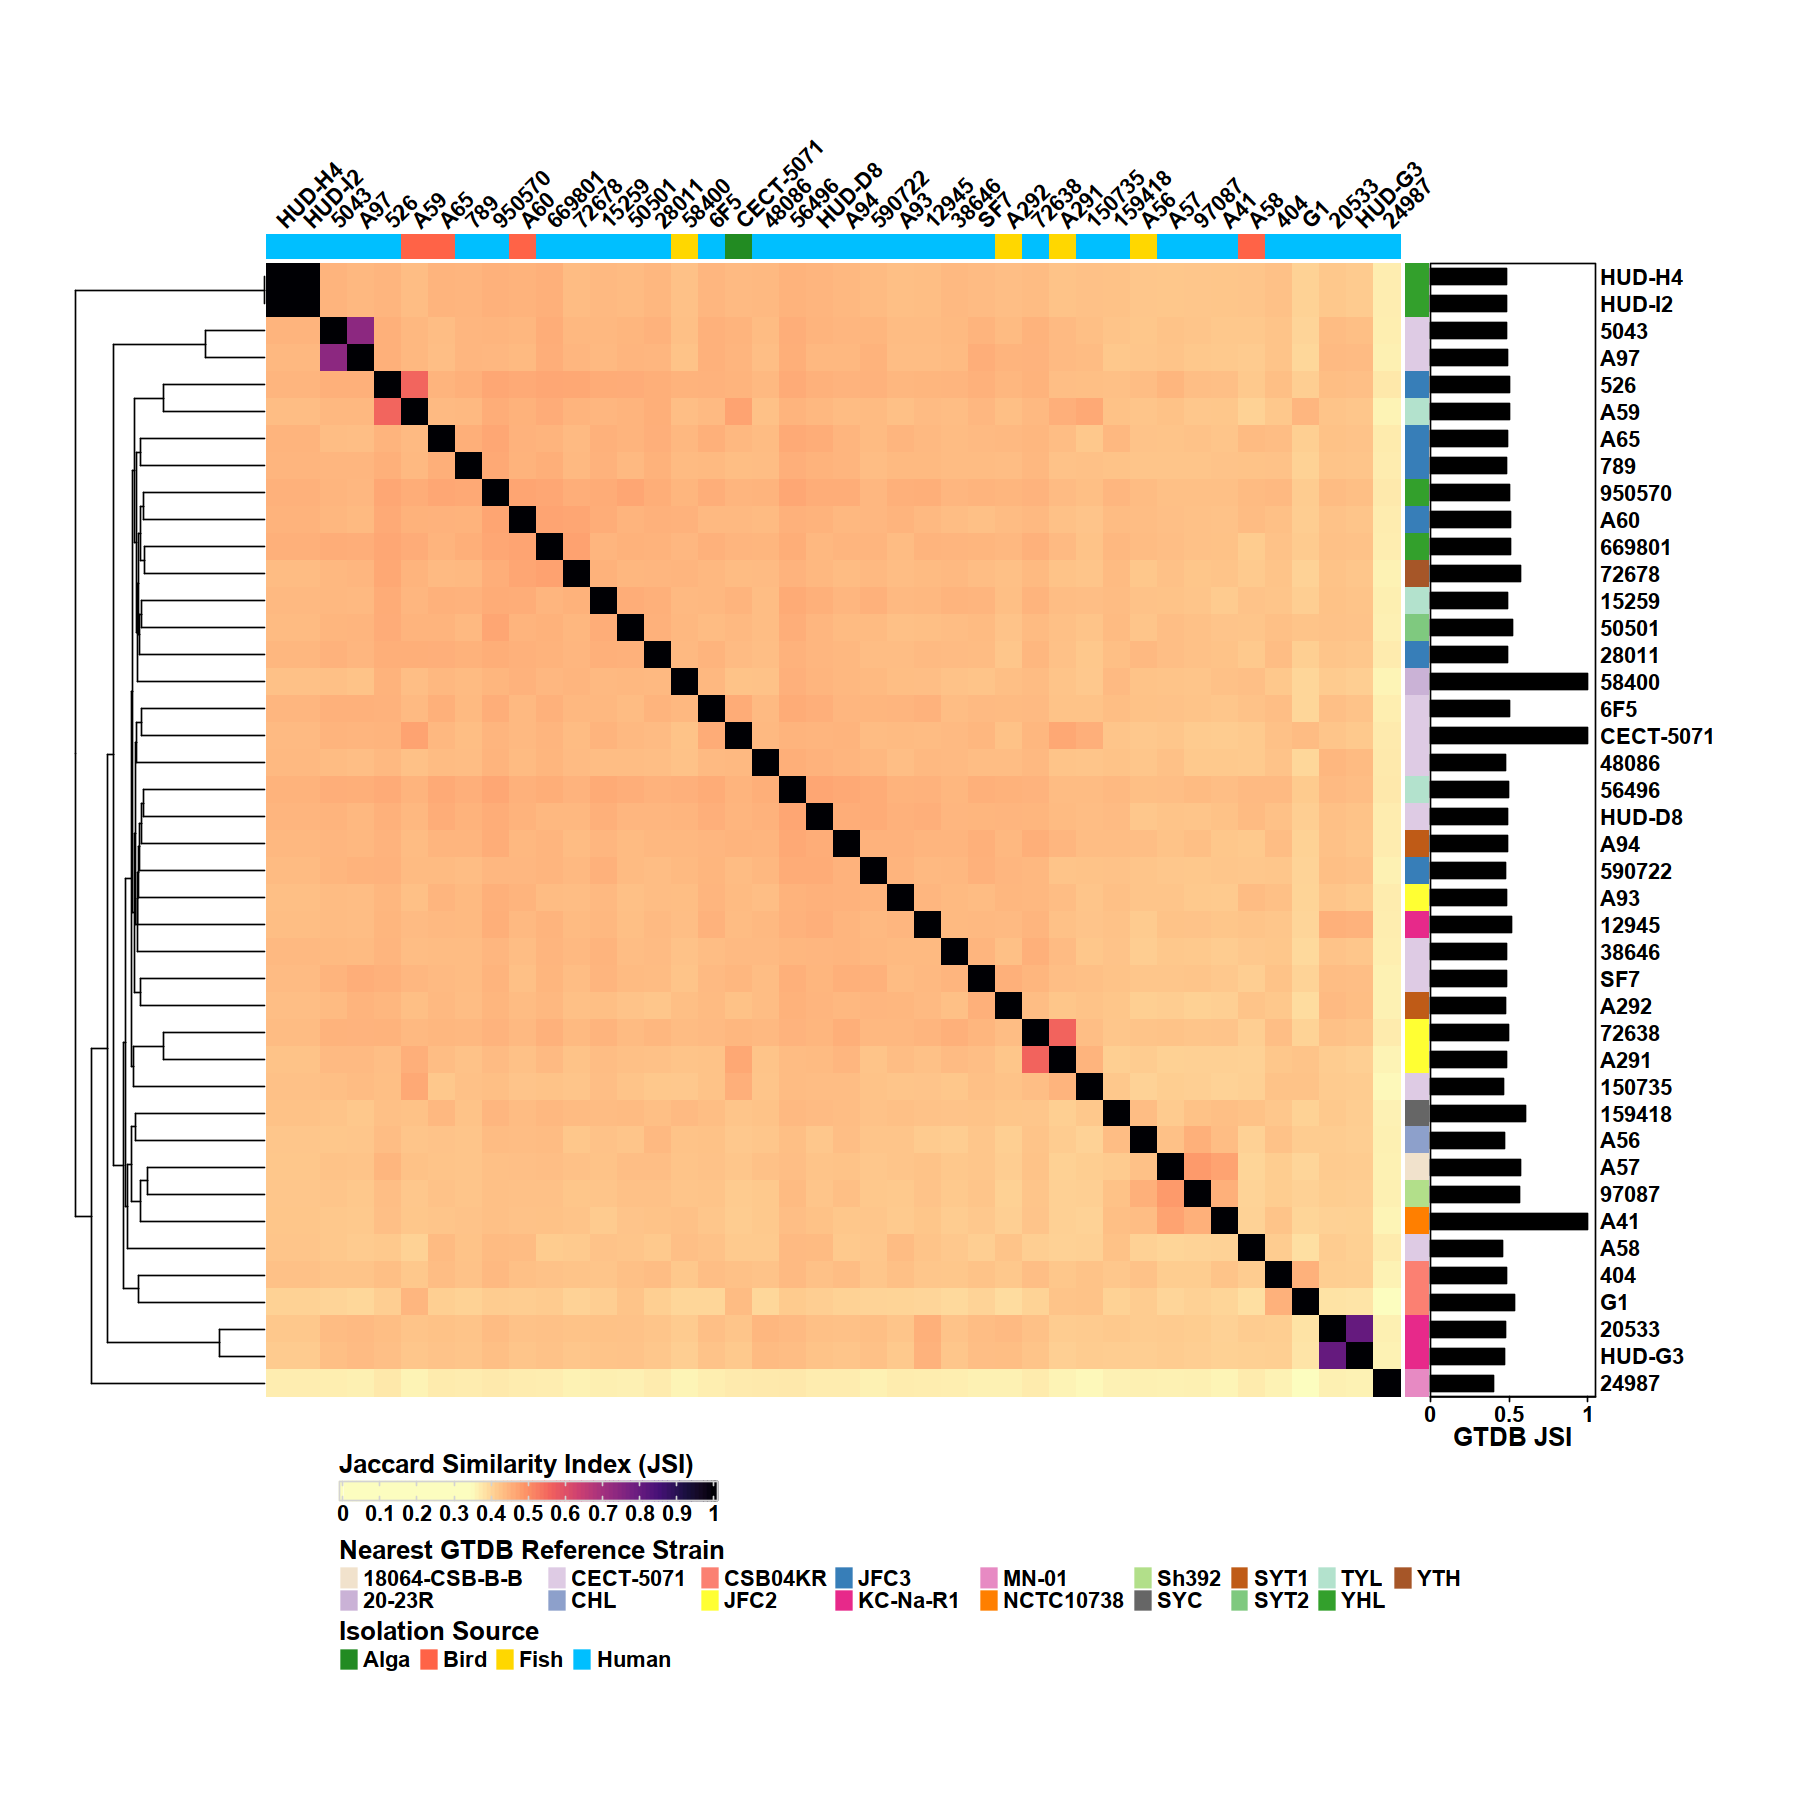

In [121]:
# Plot

## set plot params
options(repr.plot.height=15, repr.plot.width = 15)

## convert df to matrix
salgae.cmp.mat <- as.matrix(smash.cmp.salgae[, 1:42])

# make 'smash_mat' numeric in type
class(salgae.cmp.mat) <- "numeric"

## set matrix color
salgae.cmp.mat.color <- magma(direction = -1, 10)

## define affiliation annotation
salgae.chm.src <- data.frame(Source = smash.cmp.salgae$source)
salgae.chm.gtdb_ref_strain <- data.frame(gtdb_ref = smash.cmp.salgae$gtdb_ref_strain, gtdb_color = smash.cmp.salgae$gtdb_color)

row_ha <- rowAnnotation(GTDB_Ref = smash.cmp.salgae$gtdb_ref_strain,
                        `GTDB JSI` = anno_barplot(smash.cmp.salgae$gtdb_similarity,
                                                  gp = gpar(fill = "black"),
                                                  width = unit(3.5, "cm"),
                                                  axis_param = list(side = "bottom",
                                                                    labels_rot = 0,
                                                                    gp = gpar(fontsize = 13, fontface = "bold"))
                                                 ),
                        col = list(GTDB_Ref = gtdb_colors),
                        annotation_legend_param = list(title_position = "topleft",
                                                       ncol = 2,
                                                       nrow = 2,
                                                       title = "Nearest GTDB Reference Strain",
                                                       labels_gp = gpar(fontsize = 13, fontface = "bold"),
                                                       title_gp = gpar(fontsize = 15, fontface = "bold")
                                                      ),
                        show_annotation_name = c(GTDB_Ref = FALSE, GTDB_Sim = TRUE),
                        annotation_name_gp = gpar(fontsize = 15, fontface = "bold")
                       )

col_ha <- HeatmapAnnotation(Source = smash.cmp.salgae$source,
                            col = list(Source = c("Human" = "deepskyblue1", "Bird" = "tomato1", "Fish" = "gold", "Alga" = "forestgreen")),
                            annotation_legend_param = list(title_position = "topleft",
                                                           nrow = 1,
                                                           title = "Isolation Source",
                                                           labels_gp = gpar(fontsize = 13, fontface = "bold"),
                                                           title_gp = gpar(fontsize = 15, fontface = "bold")
                                                          ),
                            show_annotation_name = c(Source = FALSE))

## Plot Matrix
salgae.cmp_chm <- 
  Heatmap(salgae.cmp.mat,
          name = "Jaccard Similarity Index (JSI)",
          height = unit(24, "cm"),
          width = unit(24, "cm"),
          cluster_rows = T,
          #rect_gp = gpar(col = "grey40", lwd = 0.05),
          heatmap_legend_param = list(at = seq(0,
                                               1, 0.1),
                                      legend_direction = "horizontal",
                                      legend_width = unit(8, "cm"),
                                      nrow = 1,
                                      border = "lightgrey",
                                      title_position = "topleft",
                                      title_gp = gpar(fontsize = 15, fontface = "bold"),
                                      labels_gp = gpar(fontsize = 13, fontface = "bold")
                                     ),
          col = salgae.cmp.mat.color,
          row_names_gp = gpar(fontsize = 13, fontface = "bold"),
          column_names_gp = gpar(fontsize = 13, fontface = "bold"),
          column_names_rot = 45,
          column_names_side = "top",
          show_column_names = TRUE,
          show_column_dend = FALSE,
          show_row_names = TRUE,
          row_dend_width = unit(4, "cm"),
          top_annotation = col_ha,
          right_annotation = row_ha
          )


## Draw Plot

draw(salgae.cmp_chm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")

# Save plot to PDF
pdf("r_plots/k31.smash.cmp_chm.pdf", width = 14, height = 13)
draw(salgae.cmp_chm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")
dev.off()

In [78]:
median(salgae.cmp.mat)
min(rowMeans(salgae.cmp.mat))
max(rowMeans(salgae.cmp.mat))
mean(salgae.cmp.mat)

[1] 0.4306388

[1] 0.3750432

[1] 0.4564171

[1] 0.4419613

In [40]:
?anno_barplot()

anno_barplot {ComplexHeatmap},R Documentation
x,"The value vector. The value can be a vector or a matrix. The length of the vector or the number of rows of the matrix is taken as the number of the observations of the annotation. If x is a vector, the barplots will be represented as stacked barplots."
baseline,"baseline of bars. The value should be ""min"" or ""max"", or a numeric value. It is enforced to be zero for stacked barplots."
which,Whether it is a column annotation or a row annotation?
border,Wether draw borders of the annotation region?
bar_width,Relative width of the bars. The value should be smaller than one.
gp,"Graphic parameters for points. The length of each graphic parameter can be 1, length of x if x is a vector, or number of columns of x is x is a matrix."
ylim,"Data ranges. By default it is range(x) if x is a vector, or range(rowSums(x)) if x is a matrix."
extend,The extension to both side of ylim. The value is a percent value corresponding to ylim[2] - ylim[1].
axis,Whether to add axis?
axis_param,parameters for controlling axis. See default_axis_param for all possible settings and default parameters.


In [173]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /ceph/home/shigdon/.conda/envs/smash-jupyter/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-2   viridisLite_0.4.0    forcats_0.5.1       
 [4] stringr_1.4.0        dplyr_1.0.7          purrr_0.3.4         
 [7] readr_1.4.0          tidyr_1.1.3          tibble_3.1.2        
[10] ggplot2_3.3.4        tidyverse_1.3.1      ComplexHeatmap_2.8.0

loaded via a

In [1]:
%%bash

conda list

# packages in environment at /ceph/home/shigdon/.conda/envs/smash-jupyter:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
_r-mutex                  1.0.1               anacondar_1    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
anyio                     3.2.0            py39hf3d152e_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
aragorn                   1.2.38               h779adbc_4    bioconda
argon2-cffi               20.1.0           py39h3811e60_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atk-1.0                   2.36.0               h3371d22_4    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
babel                     2.9.1              pyh44b312d_